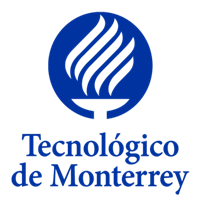

## Computer Vision (Gpo 10)

### Professors: 
* Dr. Gilberto Ochoa Ruiz
* Mtra. Yetnalezi Quintas Ruiz

### Students: 
* Armando Bringas Corpus - A01200230
* Guillermo Alfonso Muñiz Hermosillo - A01793101
* Jorge Luis Arroyo Chavelas - A01793023
* Samantha R Mancias Carrillo - A01196762
* Sofia E Mancias Carrillo - A01196563




# Image Segmentation - Watershed